## Example to recreate plots generated by `pacs_model`

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import pacs_model as pm

%matplotlib notebook

### Initial setup
 - Read in the parameter file from the fit
 - Read in the observational data
 - Do a little setup of annotation and model
 - Get the PSF the model will be convolved with

In [2]:
# get the fit
with open('../examples/LTT 8704/params.pickle','rb') as f:
    p = pickle.load(f)

In [3]:
# get the original data
obs = pm.Observation('../data/hpacs_25HPPHPFMAPB_blue_2148_m4718_00_v1.0_1470613086843.fits.gz',
                    target_ra=p['ra'], target_dec=p['dec'], dist=p['distance'])

In [4]:
# set up some things
name = ''
annotation = '\n'.join([f'{obs.wav} μm image (level {(obs.level / 10):g})',
                        f'ObsID: {obs.obsid}',
                        name if name != '' else obs.name])
npart = 100000
hires_scale = 5

In [5]:
# get the PSF
psf = pm.Observation('../psf/gamma_dra_70/1342217404/level2_5/HPPHPFMAPB/hpacs_25HPPHPFMAPB_blue_1757_p5129_00_v1.0_1470980845846.fits.gz',
                     hires_scale=hires_scale, rotate_to=obs.angle, normalize=True)

### Noise estimation and PSF subtraction
 - Re-read the observation this time giving the PSF
 - Set some parameter limits
 - Do PSF subtraction
 
This isn't necessary unless the PSF subtraction is going to be plotted

In [6]:
# now we have the PSF we can estimate the noise in the image
# by reading it again with the psf as an argument
obs = pm.Observation('../data/hpacs_25HPPHPFMAPB_blue_2148_m4718_00_v1.0_1470613086843.fits.gz',
                     target_ra=p['ra'], target_dec=p['dec'], psf=psf, dist=p['distance'])

Generating PSF fit uncertainty map...


In [7]:
# and some more things, here related to the model
model_type = pm.ModelType.Particle

param_limits = pm.ParamLimits(
                           fmax = 200000,                                               #mJy
                           shiftmax = 5,                                                #PACS pixels
                           rmax = min(obs.image.shape) * obs.aupp / np.sqrt(2),         #au
                           imax = 90 if model_type == pm.ModelType.Particle else 88,    #deg
                           alphamin = None, alphamax=None,
                           drmax = None
                          )

In [8]:
# and find the best PSF subtraction
psfsub = obs.best_psf_subtraction(psf, param_limits=param_limits)

### Make the plot
Here this uses the classes in pacs_model, which having plotting inbuilt.

The image arrays are accessible as e.g. `model.image`

<IPython.core.display.Javascript object>


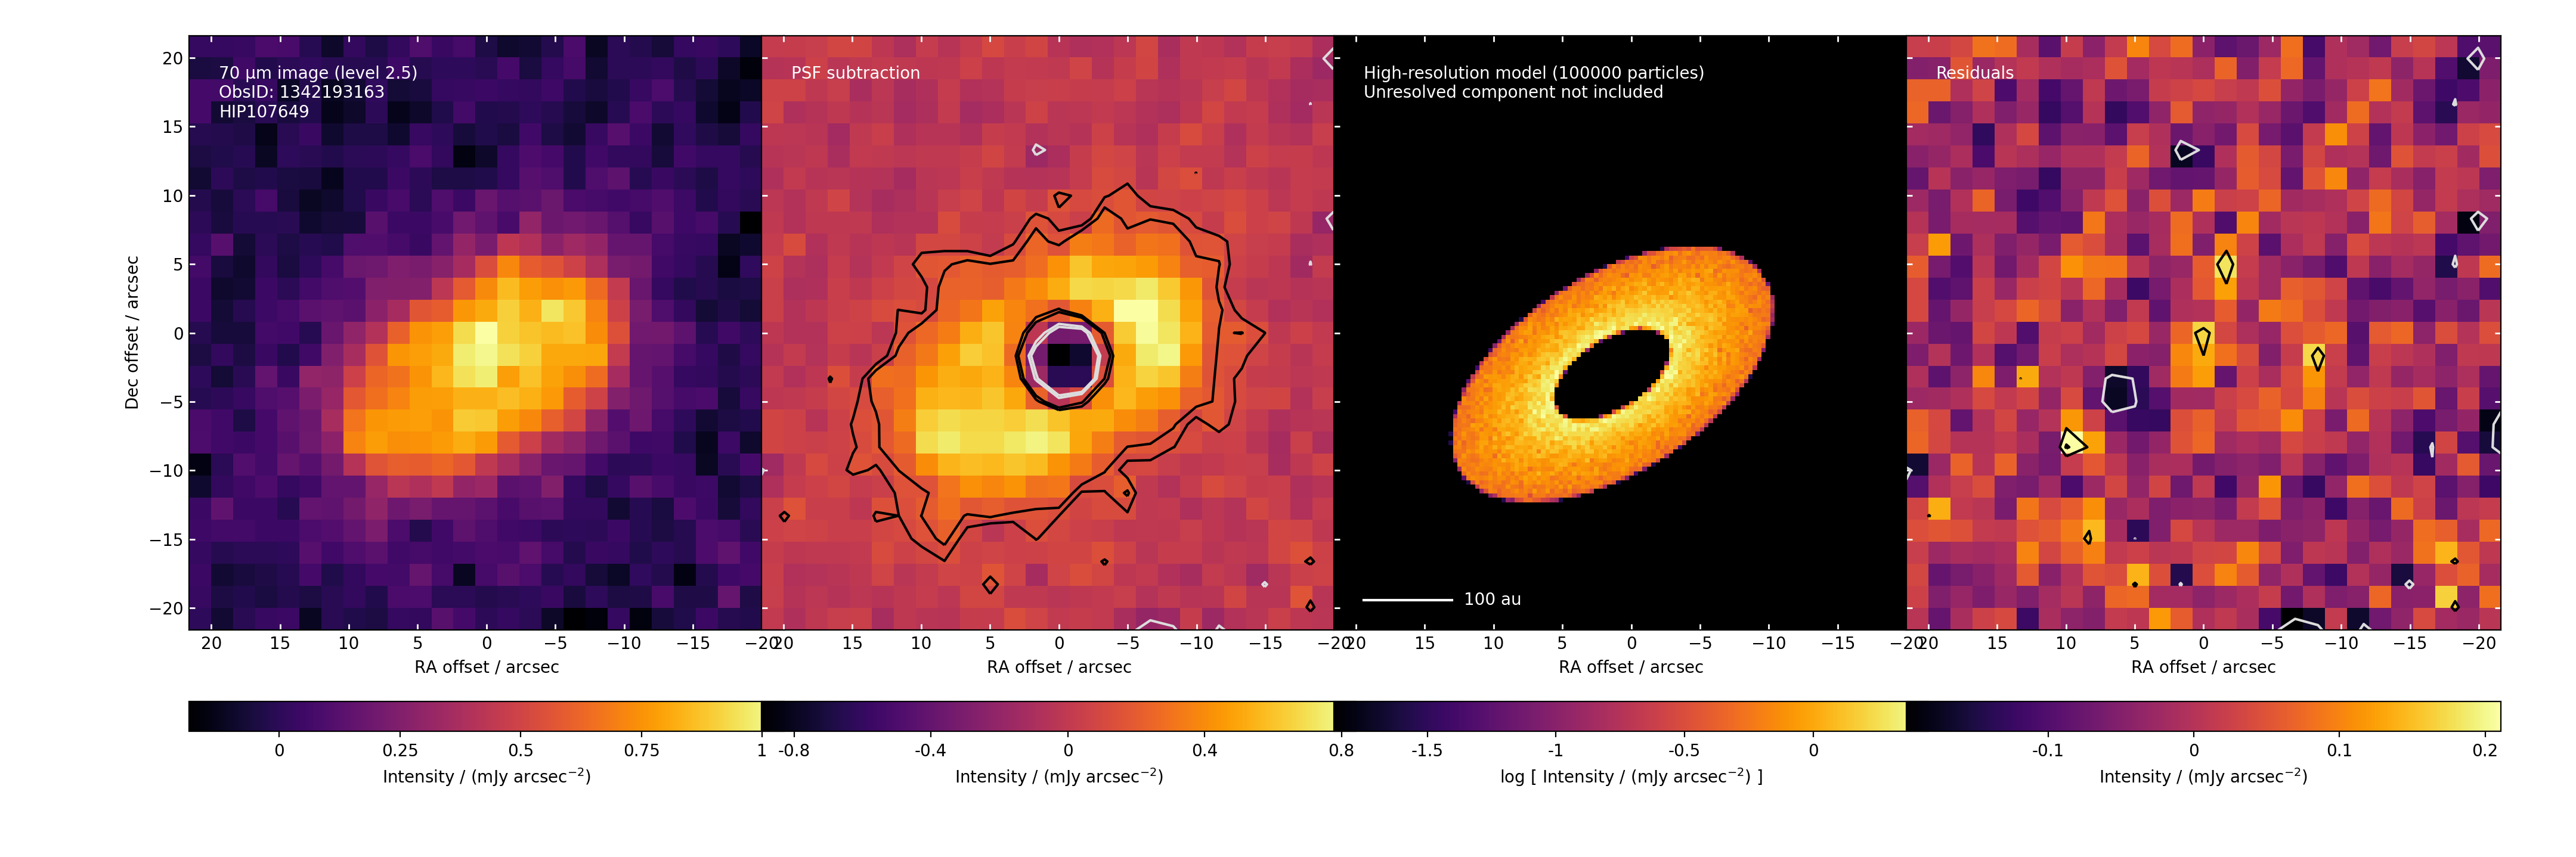

../pacs_model.py:268: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(image * intensity_scale) if log else image * intensity_scale,


In [9]:
model = pm.Model(p['max_likelihood'], obs.image.shape, obs.pfov, obs.aupp, hires_scale, 1.5,
              p['include_unres'], p['stellarflux'], obs.flux_factor, pm.ModelType.Particle, npart)

model.make_images(psf)

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (18*0.6, 6*0.6), sharey = True)

#first plot the PACS data
obs.plot(ax[0], annotation = annotation)

#then the PSF subtraction
psfsub.plot(ax[1], ylabel = False, annotation = 'PSF subtraction')
psfsub.plot_contours(ax[1], obs.rms)

#now the high-res model
annotation_model = 'High-resolution model '
annotation_model += f'({npart} particles)' if model_type == pm.ModelType.Particle else '(geometric)'
annotation_model += f'\nUnresolved component{" " if p["include_unres"] else " not "}included'

if not obs.in_au:
    annotation_model += f"\nNo distance{' or stellar flux ' if p['stellarflux'] == 0 else ' '}provided"
elif p['stellarflux'] == 0:
    annotation_model += '\nNo stellar flux provided'

model.plot(ax[2], ylabel = False, plot_hires = True, annotation = annotation_model,
           scalebar = obs.in_au, dist = p['distance'], log = True)


#finally, the model residuals
residual = obs - model
residual.plot(ax[3], ylabel = False, annotation = 'Residuals')
residual.plot_contours(ax[3], obs.rms)

plt.tight_layout()
fig.subplots_adjust(wspace=-0.1)
# fig.savefig('tmp.pdf')